## Missing Fingers

In [35]:
import warnings
from typing import List
import tqdm
import pyro
import pyro.distributions as dist
import torch
import numpy as np
import probability_on_trial as pot

Building Core model:

In [20]:
pyro.set_rng_seed(42)

import matplotlib.pyplot as plt 


pr_identity =   1/50   # high prior at this point, given other circumstantial information (tip from a woman, travel pattern, etc)
rmp_fingers_sweden = 2 / 20000 # RMP for Sweden
pr_fingers_match_if_isis = 2 / 2000 # RMP for ISIS memebers; for now a precise number 

def swedish_fingers_guilt_precise_core(
    pr_identity: float = pr_identity, 
    rmp_fingers_sweden: float =rmp_fingers_sweden,  
    pr_fingers_match_if_isis: float = pr_fingers_match_if_isis,  
    num_particles=3e6,  
):

    with pyro.plate("particles", size=num_particles):

        
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        fingers_match_sweden = pyro.sample(
            "fingers_match_sweden",
            # if guilty then 1
            # if not guilty then sample with probability rmp
            dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)),
        )

        fingers_match_isis =   pyro.sample("fingers_match_isis",
            dist.Bernoulli(
                guilty * 1
                + (1 - guilty) * pr_fingers_match_if_isis
                                ),
        )
        

    # Evidence mask 1: fingers match
    evidence_mask_fingers_sweden = (fingers_match_sweden).bool()
    guilty_masked_fingers_sweden = pyro.deterministic(
        "guilty_masked_fingers_sweden",
        torch.where(evidence_mask_fingers_sweden, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_sweden = pyro.deterministic(
        "posterior_guilty_fingers_sweden", torch.nanmean(guilty_masked_fingers_sweden, axis=0)
    )

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis).bool()
    

    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis"        ,
        torch.nanmean(guilty_masked_fingers_isis, axis=0),
    )

    return {
        "posterior_guilty_fingers_sweden": posterior_guilty_fingers_sweden,
        "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis,
    }




pyro.set_rng_seed(422323)
outcome = swedish_fingers_guilt_precise_core()
print(outcome)

posterior_sweden = outcome["posterior_guilty_fingers_sweden"]
posterior_isis = outcome["posterior_guilty_fingers_isis"]

{'posterior_guilty_fingers_sweden': tensor(0.9949), 'posterior_guilty_fingers_isis': tensor(0.9540)}


In [ ]:
epochs_iter = tqdm.notebook.tqdm(range(len(isis_grid)), desc="Combination")
for (pr, isis) in zip(prior_grid, isis_grid):

In [37]:


prior_options = torch.linspace(0.001,0.1, 30)
isis_options = torch.linspace(1, 20, 30) * 2/20000

prior_grid, isis_grid = torch.meshgrid(prior_options, isis_options)

prior_flat = prior_grid.flatten()
isis_flat = isis_grid.flatten()

sweden_list = []
isis_list = []
i = 0

iter = tqdm.notebook.tqdm(range(len(isis_flat)), desc="Combination")
for i in iter:
    pr = prior_flat[i]
    isis = isis_flat[i]

    outcome =  swedish_fingers_guilt_precise_core(pr_identity=pr, 
                                             pr_fingers_match_if_isis=isis)
    sweden_list.append(outcome["posterior_guilty_fingers_sweden"])
    isis_list.append(outcome["posterior_guilty_fingers_isis"])


Combination:   0%|          | 0/900 [00:00<?, ?it/s]

bone


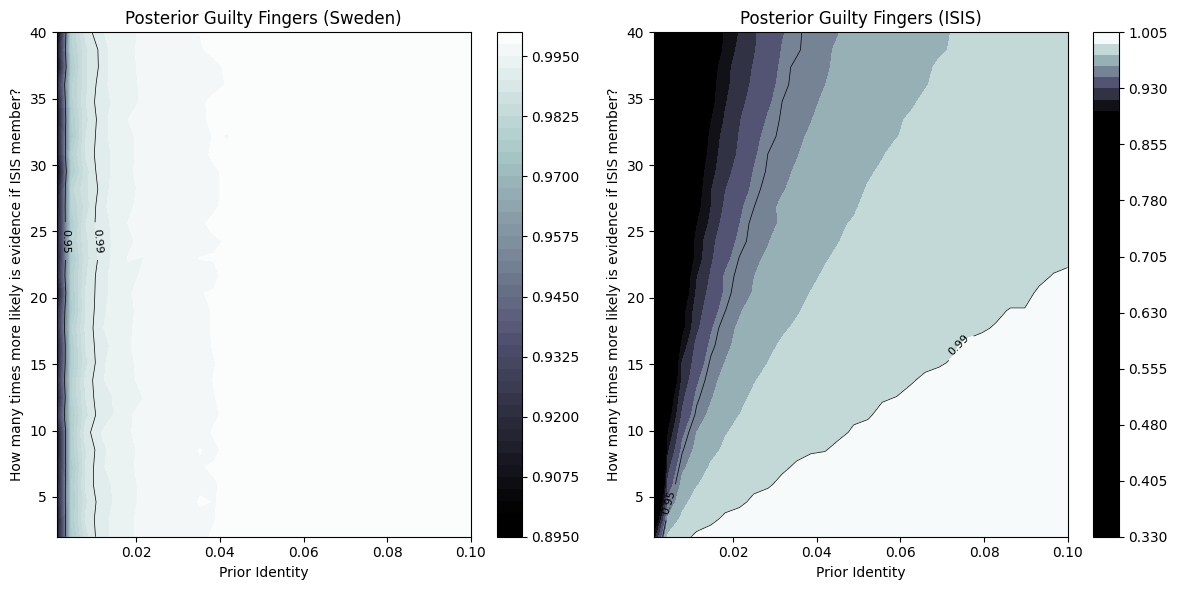

In [113]:
import matplotlib.ticker as ticker

Norm = plt.Normalize(vmin=0.9, vmax=1)

grid_shape = (len(prior_options), len(isis_options))
sweden_array = np.clip(np.array(sweden_list).reshape(grid_shape),a_min = 0, a_max = 1)
isis_array = np.clip(np.array(isis_list).reshape(grid_shape), a_min = 0, a_max = 1)

# Create the contour plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colormaps = plt.colormaps()

cmap = colormaps[40]

print(cmap)

c1 = ax[0].contourf(prior_options.numpy(), isis_options.numpy(), sweden_array.T, levels=50,
                    cmap=cmap, norm = Norm)
clines1 = ax[0].contour(prior_options.numpy(), isis_options.numpy(),
                        sweden_array.T, levels=[0.95, .99], colors='k', linewidths=0.5)
ax[0].clabel(clines1, inline=True, fontsize=8, fmt="%.2f")
ax[0].set_title("Posterior Guilty Fingers (Sweden)")
ax[0].set_xlabel("Prior Identity")
formatter = ticker.FuncFormatter(lambda x, _: f"{x * 20000:,.0f}")
ax[0].yaxis.set_major_formatter(formatter)
ax[0].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c1, ax=ax[0])

# Plot for ISIS
c2 = ax[1].contourf(prior_options.numpy(), isis_options.numpy(), isis_array.T, levels=50, 
                    cmap=cmap, norm = Norm )
clines2 = ax[1].contour(prior_options.numpy(), isis_options.numpy(),
                        isis_array.T, levels=[0.95, 0.99], colors='k', linewidths=0.5)
ax[1].clabel(clines2, inline=True, fontsize=8, fmt="%.2f")
ax[1].set_title("Posterior Guilty Fingers (ISIS)")
ax[1].set_xlabel("Prior Identity")
ax[1].yaxis.set_major_formatter(formatter)
ax[1].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()

In [ ]:
epochs_iter = tqdm.notebook.tqdm(range(len(isis_grid)), desc="Combination")
for (pr, isis) in zip(prior_grid, isis_grid):
    
    outcome =  swedish_fingers_guilt_precise_core(pr_identity=pr, 
                                             pr_fingers_match_if_isis=isis)
    
    sweden_list.append(outcome["posterior_guilty_fingers_sweden"])
    isis_list.append(outcome["posterior_guilty_fingers_isis"])
    #epochs_iter.set_postfix(loss=loss.item())

In [3]:
# requires pyro 1.9.1
#pyro.render_model(swedish_fingers_guilt_model, render_deterministic=True)

In [9]:
posterior_guilt_sweden = torch.tensor(
    [
        1 - posterior_sweden,
        posterior_sweden,]
)

posterior_guilt_isis = torch.tensor(
    [
    1 - posterior_isis,
        posterior_isis
    ]
)

prior_guilt = torch.tensor([1 - pr_identity, pr_identity])


print("posterior_guilt_no_isis_info", posterior_guilt_sweden)
print("posterior_guilt_isis", posterior_guilt_isis)


print(
"sweden", pot.weight(posterior_guilt_sweden, prior_guilt)
)

print(
"isis", pot.weight(posterior_guilt_isis, prior_guilt)
)

print(posterior_guilt_isis)
print(prior_guilt)


posterior_guilt_no_isis_info tensor([0.0291, 0.9709])
posterior_guilt_isis tensor([0.1064, 0.8936])
sweden tensor(0.7035)
isis tensor(0.3123)
tensor([0.1064, 0.8936])
tensor([0.9967, 0.0033])


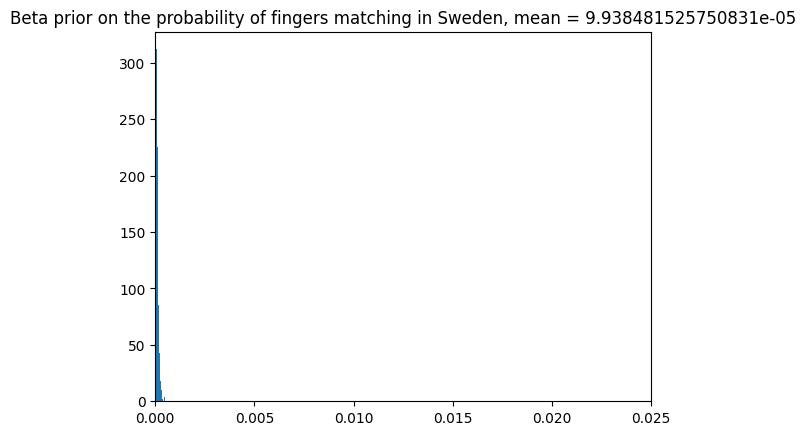

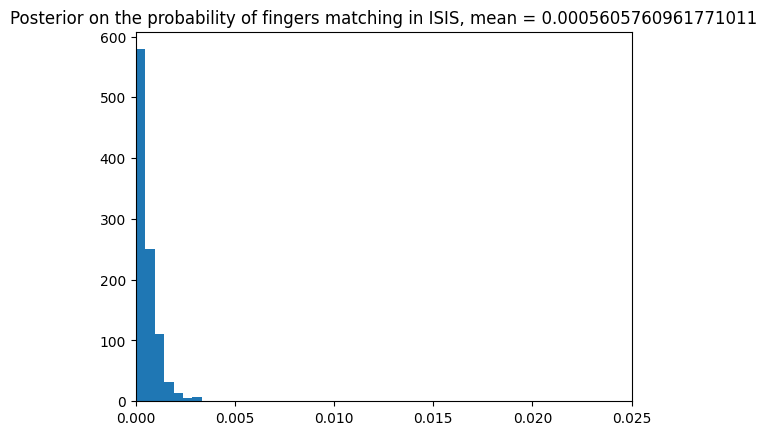

In [5]:
with pyro.plate("samples", 1000):
    probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))

plt.hist(probs_sweden)
plt.title(f"Beta prior on the probability of fingers matching in Sweden, mean = {probs_sweden.mean()}")
plt.xlim(0,.025)
plt.show()

with pyro.plate("multipliers", 1000):
    multiplier = pyro.sample("probs_isis", dist.Uniform(1, 10))
    probs_isis = (probs_sweden * multiplier).clamp(0, 1)

plt.hist(probs_isis)
plt.title(f"Posterior on the probability of fingers matching in ISIS, mean = {probs_isis.mean()}")
plt.xlim(0,.025)
plt.show()

In [26]:
bayesian_samples = 2000

def bayesian_missing_fingers():
    outcomes = []

    with pyro.plate("bayesia_samples", bayesian_samples):
        probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))
        multiplier = pyro.sample("probs_isis", dist.Uniform(1, 100))
        probs_isis = (probs_sweden * multiplier).clamp(0, 1)

        outcomes = swedish_fingers_guilt_precise_core(rmp_fingers_sweden= probs_sweden, 
                                                      pr_fingers_match_if_isis=probs_isis,
                                                      num_particles=3e5)

# TODO weigths should be refactor to allow for batched computations, then this loop should be replaced by tw single calls to pot.weight
        sweden_weights = []
        isis_weights = []
        for i in range(bayesian_samples):
            sweden_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_sweden'][i],  outcomes['posterior_guilty_fingers_sweden'][i]])
            isis_distro = torch.tensor([1 - outcomes['posterior_guilty_fingers_isis'][i], outcomes['posterior_guilty_fingers_isis'][i]])

            sweden_weights.append(pot.weight(sweden_distro, prior_guilt))
            isis_weights.append(pot.weight(isis_distro, prior_guilt))

    outcomes['sweden_weights'] = sweden_weights 
    outcomes['isis_weights'] = isis_weights


    return outcomes


bayesian_samples = bayesian_missing_fingers()

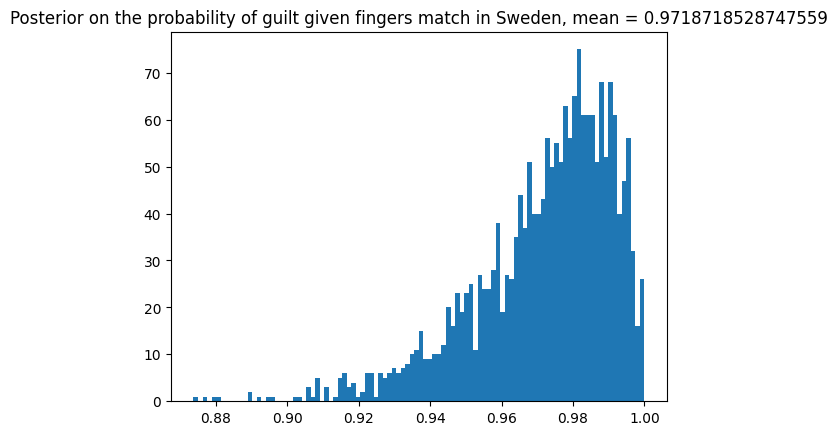

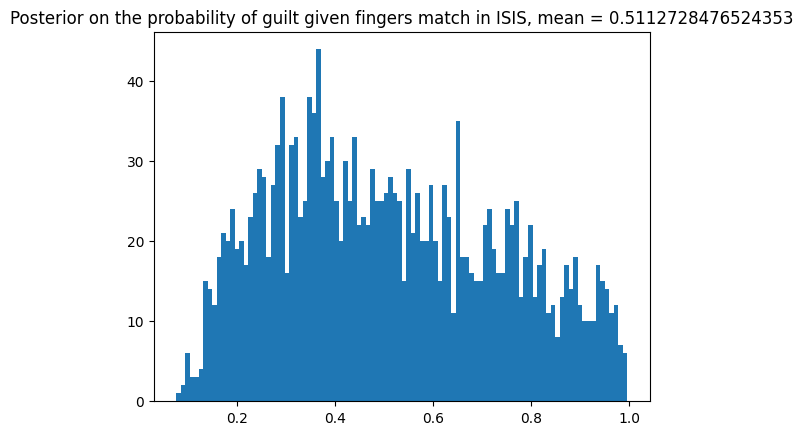

In [27]:
plt.hist(bayesian_samples["posterior_guilty_fingers_sweden"], bins = 100)
plt.title(f"Posterior on the probability of guilt given fingers match in Sweden, mean = {bayesian_samples['posterior_guilty_fingers_sweden'].mean()}")
plt.show()


plt.hist(bayesian_samples["posterior_guilty_fingers_isis"], bins = 100)
plt.title(f"Posterior on the probability of guilt given fingers match in ISIS, mean = {bayesian_samples['posterior_guilty_fingers_isis'].mean()}")
plt.show()


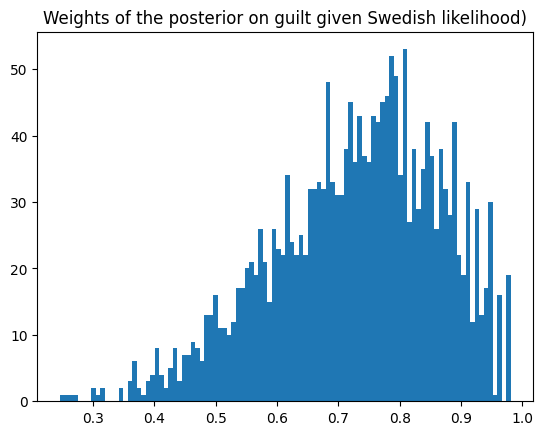

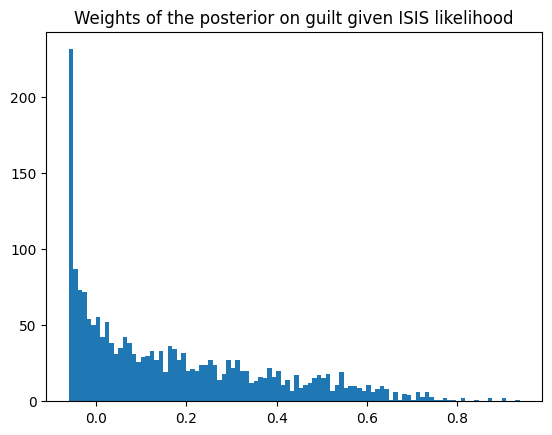

In [28]:
plt.hist(bayesian_samples['sweden_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given Swedish likelihood)")
plt.show()

plt.hist(bayesian_samples['isis_weights'], bins = 100)
plt.title(f"Weights of the posterior on guilt given ISIS likelihood")
plt.show()

